# Define your own problem

Apart from giving you access to already implemented problems, QLauncher allows you to easily define your own problems.

To define a problem you need two key components, problem initialization and problem formulations in at least one of the formats used by quantum computers such as QUBO, Hamiltonian or BQM.

In this tutorial we will implement the initialization and formulation for the Vertex Cover problem.

## Problem initialization

To complete a problem initialization you need to create a subclass of class problem. When you initialize it it takes as an argument an object of problem instance in any form, e.g. a graph if the problem is graph based.

In [1]:
from qlauncher.base import Problem
import networkx as nx


class VertexCover(Problem):
    pass


graph = nx.from_edgelist([(0, 1), (0, 2), (1, 3), (2, 3), (2, 4), (3, 4)])
pr = VertexCover(graph)

You could leave the class declaration like that, but in practice it might be worth to define a set of helper functions, such as one generating a random instance, reading an instance from a file or visualizing the problem with some proposed solution:

In [2]:
from qlauncher.base import Problem
import pickle
import matplotlib.pyplot as plt


class VertexCover(Problem):

    # method to visualize a problem and optionally a solution to it
    def visualize(self, solution: list[int] | None = None):
        pos = nx.spring_layout(self.instance)
        plt.figure(figsize=(8, 6))
        if solution is not None:
            solution_colors = ["red" if x else "skyblue" for x in solution]
            nx.draw_networkx_nodes(self.instance, pos, node_size=500, node_color=solution_colors)
        else:
            nx.draw_networkx_nodes(self.instance, pos, node_size=500, node_color="skyblue")
        nx.draw_networkx_edges(self.instance, pos, edge_color="gray")
        nx.draw_networkx_labels(self.instance, pos, font_size=10, font_weight="bold")
        plt.title("Vertex Cover Problem Instance Visualization")
        plt.show()

    # method to load a predefined toy example
    @staticmethod
    def from_preset(instance_name: str) -> "VertexCover":
        match instance_name:
            case 'default':
                node_list = list(range(5))
                edge_list = [(0, 1), (0, 2), (1, 3), (2, 3), (2, 4), (3, 4)]
        graph = nx.Graph()
        graph.add_nodes_from(node_list)
        graph.add_edges_from(edge_list)
        return VertexCover(graph, instance_name=instance_name)

    # method to load problem instance from file
    @staticmethod
    def from_file(path: str) -> "VertexCover":
        with open(path, 'rb') as f:
            graph = pickle.load(f)
        return VertexCover(graph, instance_name=path)

    # method to save problem instance to file
    def to_file(self, path: str):
        with open(path, 'wb') as f:
            pickle.dump((self.instance), f, pickle.HIGHEST_PROTOCOL)

    # method which generates ransom problem instance
    @staticmethod
    def generate_vertex_cover_instance(num_vertices: int, edge_probability: int) -> "VertexCover":
        graph = nx.gnp_random_graph(num_vertices, edge_probability)
        return VertexCover(graph)

Here we will use one of the methods we just implemented to see the graph matching the provided edge list.

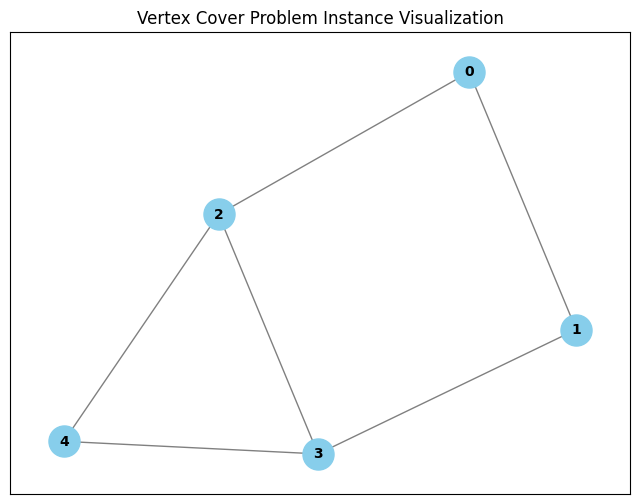

In [3]:
graph = nx.from_edgelist([(0, 1), (0, 2), (1, 3), (2, 3), (2, 4), (3, 4)])
pr = VertexCover(graph)
pr.visualize()

## Problem Formulation

To add a problem formulation you need to define a callable, a function or callable class, and decorate it with the formatter decorator.

The formatter decorator needs to be provided with two arguments, the class of a problem you add a formulation for and format in which problem formulation will be returned e.g. \"qubo\" or \"hamiltonian\". Additionally, the decorated function needs to take an instance of the specified problem class and return a problem formulation in the selected format.

### Qubits and Penalty Function

To create a proper problem formulation you need to do two things:

1. Find a way to express a solution (any solution, not just the optimal one) as a set of binary variables, those binary variables will be mapped to qubits by a quantum computer.
2. Construct a penalty function which acts on the qubit representation and based on the values of qubits assigns a "penalty" to it, for the quantum algorithm to work properly the penalty function should assign higher values to invalid or suboptimal solutions and lower values, possibly 0, to an optimal solution.

The penalty function needs to follow a format specified in the formatter, e.g. a QUBO formulation needs to be a polynomial of at most second order expressed as a QUBO matrix and offset where $i'th$, $j'th$ matrix entry corresponds to the coefficient of $x_{i}x_{j}$ term in the function and offset corresponds to the constant. On the other hand the Hamiltonian formulation can be of higher order and needs to be represented by a SparsePauliOp from the qiskit library.

Below you can see a formulation of the vertex cover problem using QUBO as a return format:

In [4]:
from qlauncher.base import formatter
from pyqubo import Array
import numpy as np


@formatter(problem=VertexCover, alg_format="qubo")
def get_qubo(problem: VertexCover, constraint_weight=5, cost_weight=1):
    vertices = problem.instance.nodes()
    edges = problem.instance.edges()
    x = Array.create("x", shape=(len(vertices),), vartype="BINARY")
    qubo = 0
    # penalty for number of vertices used
    for v in vertices:
        qubo += cost_weight*x[v]
    # penalty for violating constraint, not covering all edges
    for e in edges:
        qubo += constraint_weight*(1-x[e[0]]-x[e[1]]+x[e[0]]*x[e[1]])
    qubo_dict, offset = qubo.compile().to_qubo()
    # turn qubo dict into qubo matrix
    Q_matrix = np.zeros((len(vertices), len(vertices)))
    for i in range(len(vertices)):
        for j in range(len(vertices)):
            key = ("x["+str(i)+"]", "x["+str(j)+"]")
            if key in qubo_dict:
                Q_matrix[i, j] = qubo_dict[key]
    return Q_matrix, offset

Now that you have created a problem initialization and formulation decorated with @formatter, you can pass an instance of the problem to QLauncher which will automatically find the formulation.

In [5]:
from qlauncher.launcher import QLauncher
from qlauncher.routines.qiskit import QAOA, QiskitBackend

pr = VertexCover.from_preset("default")

solution = QLauncher(pr, QAOA(p=5), QiskitBackend("local_simulator")).run()
solution

Result(bitstring=01110, energy=4.7587890625)

We can once again use the problem's visualize method, this time to check the solution's correctness, unfortunately due to algorithm's indeterminism we cannot guarantee the correct solution each time

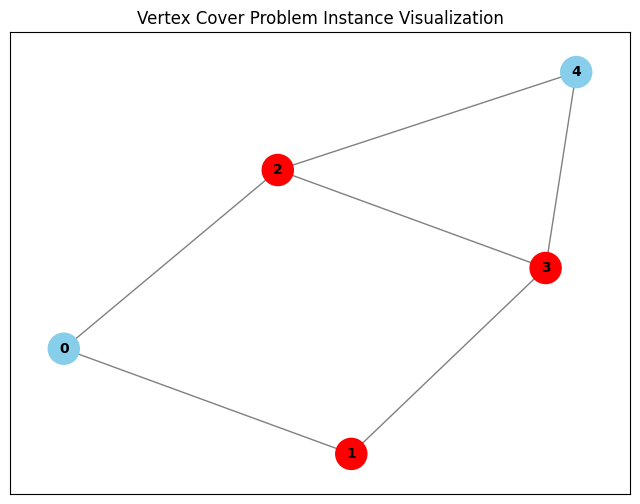

In [6]:
pr.visualize([int(x) for x in solution.best_bitstring])

A nice convenience introduced by QLauncher is the fact that you don't need to define formulations in both formats, QLauncher uses adapters which allow it to transform between problem formulations. Since QAOA requires the problem to be formulated as a Hamiltonian and we provided a QUBO formulation, QLauncher will use a QUBO to hamiltonian adapter, which looks as follows:

In [7]:
from qiskit.quantum_info import SparsePauliOp
from qlauncher.base.adapter_structure import adapter


@adapter("qubo", "hamiltonian")
def qubo_to_hamiltonian(qubo: np.ndarray) -> SparsePauliOp:
    q_matrix, offset = qubo
    num_vars = q_matrix.shape[0]
    pauli = 0
    for i, col in enumerate(q_matrix):
        for j, entry in enumerate(col):
            if entry == 0:
                continue
            if i == j:
                pauli += SparsePauliOp.from_sparse_list([('I', [0], .5), ('Z', [i], -.5)], num_vars)*entry
            else:
                pauli += SparsePauliOp.from_sparse_list([('I', [0], .25), ('Z', [i], -.25),
                                                        ('Z', [j], -.25), ('ZZ', [i, j], .25)], num_vars)*entry
    pauli += SparsePauliOp.from_sparse_list([('I', [], offset)], num_vars)
    return pauli